## Bibliotecas

In [681]:
using LinearAlgebra
using Plots
using GaussQuadrature
using SparseArrays

## Definição das f's das equações e suas soluções analíticas 

In [682]:
function f1(x::Float64, α::Float64, β::Float64)
    return -2*α + β*(x^2-x)
end

function f1_solution(x::Float64)
    return x*(x-1)
end

function f2(x::Float64, α::Float64, β::Float64)
    return (α*π^2 + β)*sin(π*x)
end

function f2_solution(x::Float64)
    return sin(π*x)
end

function f3(x::Float64, α::Float64, β::Float64)
    return 8.0::Float64
end

function f3_solution(x::Float64)
    return -4*x*(x-1)::Float64
end

function f4(x::Float64, α::Float64, β::Float64)
    return x::Float64
end

function f4_solution(x::Float64)
    return x + (exp(-x) - exp(x))/(exp(1) - exp(-1)) ::Float64
end

f4_solution (generic function with 1 method)

## Funções auxiliares

In [683]:
function get_point(index::Int64, m::Int64)
    return convert(Float64, index/(m+1))     
end

function solution_on_points(α::Float64, β::Float64, m::Int64, f)
    exact_solution = zeros(m)
    for i in 1:m
        point = get_point(i, m)
        exact_solution[i] = f(point)::Float64
    end

    prepend!(exact_solution, f(0.0))
    append!(exact_solution, f(1.0))

    return exact_solution
end

function monta_K(α::Float64, β::Float64, m::Int64)
    h = 1/(m+1) 

    diag_principal = fill(2.0*α/h + 2.0*β*h/3.0, m)     # Diagonal principal
    diag_superior_infeiror  = fill(-α/h + β*h/6.0, m-1) # Diagonal superior e inferior

    K = SymTridiagonal(diag_principal, diag_superior_infeiror)  # Cria a matriz tridiagonal


    return K
    
end

function plot_exact_and_numerical(m::Int64, f_exact, sol_on_points, isContinous::Bool)
    points = get_point.(0:m+1, m)
    plot(f_exact, range(0, 1, 100), lw=3, label="Solução Exata")

    if(isContinous)
        plot!(points, sol_on_points, lw=3, markershape=:circle, label="Solução Numérica")
    else 
        plot!(points, sol_on_points, lw=3, seriestype=:scatter, label="Solução Numérica")
    end

end

function plot_erro(n_testes, f_eq, f_exact)
    erros = []
    m_list = (2 .^(2:n_testes)) .- 1
    h_list = 1.0 ./ (m_list .+ 1)

    for m in m_list
        points = get_point.(1:m, m)

        uh = solve_equation(α, β, m, f_eq)
        u = f_exact.(points)
        prepend!(u, f_exact(0.0))
        append!(u, f_exact(1.0))    

        
            erro = norm(u - uh, Inf)

        push!(erros, erro)
    end

    display([h_list erros])

    plot(h_list, erros, lw=3, label="Erro", xscale = :log10, yscale = :log10, markershape=:circle)
    plot!(h_list, h_list.^2, lw=3, label="h²", xscale = :log10, yscale = :log10, legend=:topleft)
end

plot_erro (generic function with 1 method)

## Solvers

In [684]:
function solve_equation(α::Float64, β::Float64, m::Int64, f)

    h = 1/(m+1) 

    main_diagonal = fill(2.0*α + β*h^2, m) # Diagonal principal
    sup_diagonal = fill(-α, m-1) # Diagonal superior e inferior

    A = SymTridiagonal(main_diagonal, sup_diagonal)  # Cria a matriz tridiagonal

    b = zeros(m)
    for i in 1:m
        
        point = get_point(i, m)
        b[i] = h^2*f(point, α, β)::Float64
    end

    num_solution = A\b
    prepend!(num_solution, 0.0)
    append!(num_solution, 0.0)
    
    return num_solution
end

function solve_via_galerkin_1(α::Float64, β::Float64, m::Int64, K::SymTridiagonal{Float64}, f)

    h = 1/(m+1) 

    b = zeros(m)
    for i in 1:m
        b[i] = 8*h

    end

    num_solution = K\b

    prepend!(num_solution, 0.0)
    append!(num_solution, 0.0)
    
    return num_solution
end

function solve_via_galerkin_2(α::Float64, β::Float64, m::Int64, K::SymTridiagonal{Float64}, f)

    h = 1/(m+1) 

    b = zeros(m)
    points = get_point.(1:m, m)
    
    for i in 1:m
        b[i] = h*points[i]
    end
    
    num_solution = K\b

    prepend!(num_solution, 0.0)
    append!(num_solution, 0.0)
    
    return num_solution
end

solve_via_galerkin_2 (generic function with 1 method)

## Caso 1

In [685]:
α = 1.0
β = 1.0
m = 4

num_sol_1 = solve_equation(α, β, m, f1)
exact_sol = solution_on_points(α, β, m, f1_solution)

display("Solução numérica: ")
display(num_sol_1)

display("Solução exata: ")
display(exact_sol)

"Solução numérica: "

6-element Vector{Float64}:
  0.0
 -0.15999999999999998
 -0.24
 -0.23999999999999994
 -0.15999999999999998
  0.0

"Solução exata: "

6-element Vector{Float64}:
 -0.0
 -0.16000000000000003
 -0.24
 -0.24
 -0.15999999999999998
  0.0

### Plot Soluções

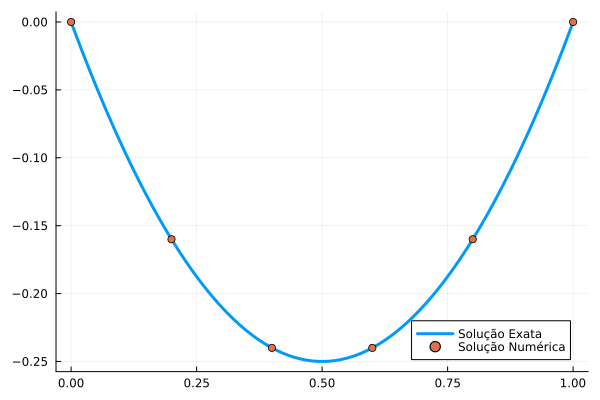

In [686]:
plot_exact_and_numerical(m, f1_solution, num_sol_1, false)

### Plot erro

19×2 Matrix{Any}:
 0.25         2.77556e-17
 0.125        2.77556e-17
 0.0625       3.88578e-16
 0.03125      1.27676e-15
 0.015625     1.30451e-15
 0.0078125    2.44249e-15
 0.00390625   2.21767e-14
 0.00195312   4.49363e-14
 0.000976562  1.16851e-13
 0.000488281  9.0622e-14
 0.000244141  1.19463e-12
 0.00012207   4.47695e-12
 6.10352e-5   9.10022e-13
 3.05176e-5   4.56901e-12
 1.52588e-5   1.38194e-10
 7.62939e-6   1.46899e-10
 3.8147e-6    1.64103e-9
 1.90735e-6   3.61146e-8
 9.53674e-7   1.98238e-8

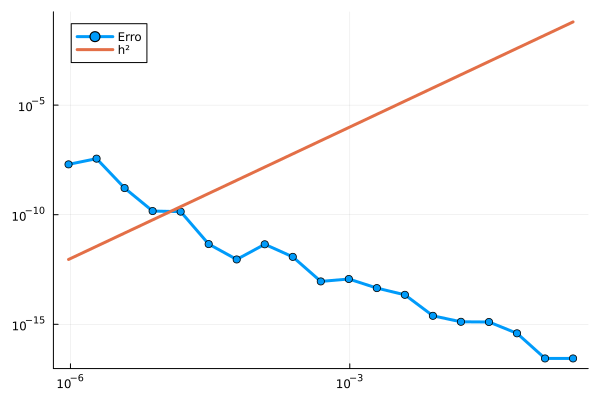

In [687]:
n_testes = 20
plot_erro(n_testes, f1, f1_solution)

## Caso 2

In [688]:
α = 1.0
β = 1.0
m = 7

num_sol_2 = solve_equation(α, β, m, f2)
exact_sol = solution_on_points(α, β, m, f2_solution)

display("Solução numérica: ")
display(num_sol_2)

display("Solução exata: ")
display(exact_sol)

"Solução numérica: "

9-element Vector{Float64}:
 0.0
 0.3871781595774367
 0.7154119541379651
 0.9347307639065021
 1.0117452882257492
 0.9347307639065022
 0.7154119541379653
 0.38717815957743673
 0.0

"Solução exata: "

9-element Vector{Float64}:
 0.0
 0.3826834323650898
 0.7071067811865475
 0.9238795325112867
 1.0
 0.9238795325112867
 0.7071067811865476
 0.3826834323650899
 1.2246467991473532e-16

### Plot soluções

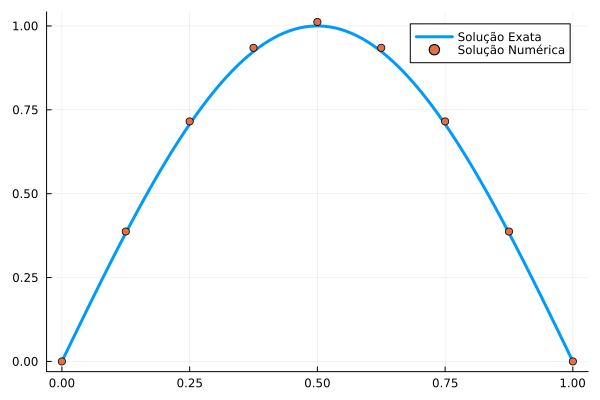

In [689]:
plot_exact_and_numerical(m, f2_solution, num_sol_2, false)

### Plot erro

19×2 Matrix{Any}:
 0.25         0.0479168
 0.125        0.0117453
 0.0625       0.00292196
 0.03125      0.000729595
 0.015625     0.000182343
 0.0078125    4.55822e-5
 0.00390625   1.13953e-5
 0.00195312   2.84882e-6
 0.000976562  7.12204e-7
 0.000488281  1.78051e-7
 0.000244141  4.45162e-8
 0.00012207   1.11428e-8
 6.10352e-5   2.78447e-9
 3.05176e-5   6.96922e-10
 1.52588e-5   3.74505e-10
 7.62939e-6   5.34526e-10
 3.8147e-6    6.56058e-9
 1.90735e-6   1.44238e-7
 9.53674e-7   8.54365e-8

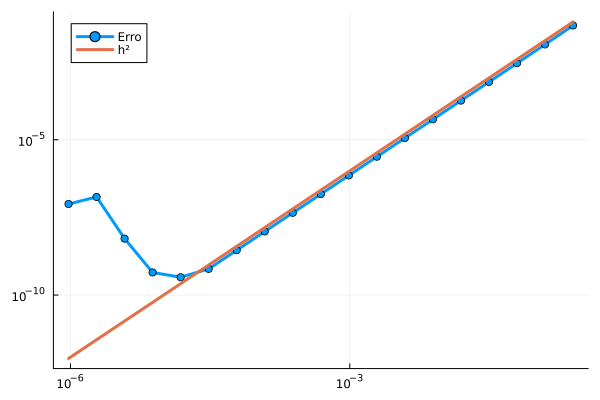

In [690]:
n_testes = 20
plot_erro(n_testes, f2, f2_solution)

## Caso 3

In [692]:
m = 10
α = 1.0
β = 0.0
K = monta_K(α, β, m)
galerkin_sol_3 = solve_via_galerkin_1(α, β, m, K, f3)

12-element Vector{Float64}:
 0.0
 0.3305785123966941
 0.5950413223140494
 0.7933884297520659
 0.9256198347107436
 0.9917355371900825
 0.9917355371900825
 0.9256198347107436
 0.7933884297520659
 0.5950413223140494
 0.3305785123966941
 0.0

### Plot soluções

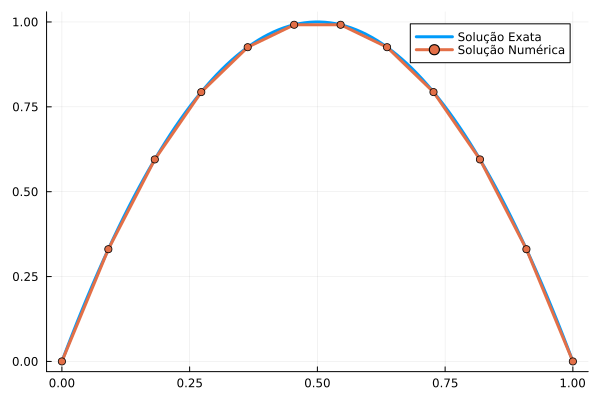

In [693]:
plot_exact_and_numerical(m, f3_solution, galerkin_sol_3, true)

### Plot erro

19×2 Matrix{Any}:
 0.25         1.11022e-16
 0.125        2.22045e-16
 0.0625       2.22045e-16
 0.03125      5.9952e-15
 0.015625     1.16573e-14
 0.0078125    5.9952e-15
 0.00390625   1.45439e-14
 0.00195312   1.09468e-13
 0.000976562  2.72782e-13
 0.000488281  4.28546e-13
 0.000244141  4.32021e-12
 0.00012207   9.85168e-12
 6.10352e-5   7.53708e-12
 3.05176e-5   5.17101e-11
 1.52588e-5   1.18841e-10
 7.62939e-6   5.14755e-10
 3.8147e-6    9.305e-9
 1.90735e-6   1.52787e-7
 9.53674e-7   2.52658e-7

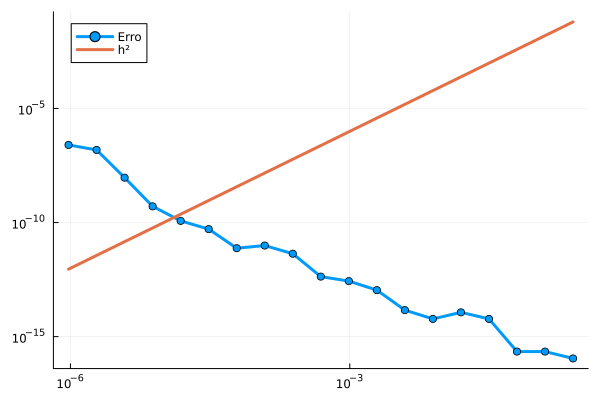

In [694]:
n_testes = 20
plot_erro(n_testes, f3, f3_solution)

## Caso 4

In [695]:
m = 10
α = 1.0
β = 1.0
K = monta_K(α, β, m)
galerkin_sol_4 = solve_via_galerkin_2(α, β, m, K, f4)

12-element Vector{Float64}:
 0.0
 0.013454587301355417
 0.026268171814233025
 0.03779444589949175
 0.0473764483144516
 0.0543411272922646
 0.05799377045832708
 0.05761225548648982
 0.052441073914289996
 0.0416850786591238
 0.024502903490666347
 0.0

### Plot soluções

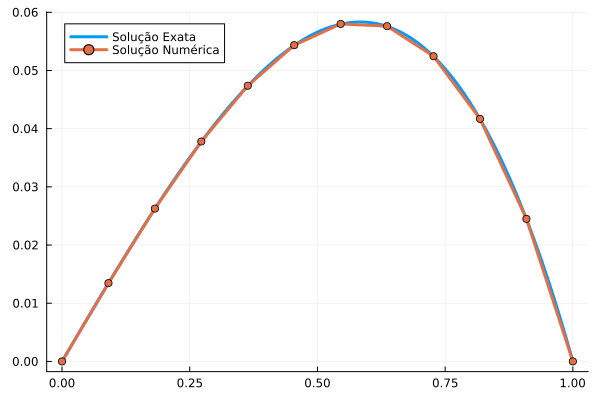

In [696]:
plot_exact_and_numerical(m, f4_solution, galerkin_sol_4, true)

### Plot erro

19×2 Matrix{Any}:
 0.25         0.000264735
 0.125        6.85766e-5
 0.0625       1.72054e-5
 0.03125      4.3176e-6
 0.015625     1.0795e-6
 0.0078125    2.69881e-7
 0.00390625   6.7474e-8
 0.00195312   1.68685e-8
 0.000976562  4.21717e-9
 0.000488281  1.05429e-9
 0.000244141  2.63476e-10
 0.00012207   6.48078e-11
 6.10352e-5   1.63828e-11
 3.05176e-5   3.88357e-12
 1.52588e-5   3.50996e-11
 7.62939e-6   2.95445e-11
 3.8147e-6    3.99285e-10
 1.90735e-6   8.49059e-9
 9.53674e-7   5.03979e-9

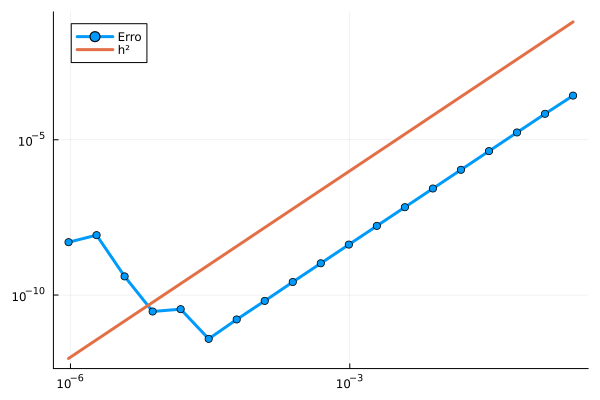

In [697]:
n_testes = 20
plot_erro(n_testes, f4, f4_solution)

## Fazendo quadratura para calcular (fᵢ ,φᵢ)

In [698]:
function map_ξ_x(ξ, x_i_inf, h)
    return x_i_inf + ((h*(ξ+1))/2.0)
end

function φ₁(ξ)
    return (1.0 - ξ)/2.0 :: Float64
end

function φ₂(ξ)
    return (1.0 + ξ)/2.0 :: Float64
end

function quadratura_base_linear(f, α, β, i, h)
    pontos, pesos = legendre(5)
    Fᵢ = 0
    x_i_inf = get_point(i-1, m)
    x_i = get_point(i, m)
    
    for (ξ, W) in zip(pontos, pesos)
        Fᵢ += W*( f(map_ξ_x(ξ, x_i_inf, h), α, β)*φ₂(ξ) + f(map_ξ_x(ξ, x_i, h), α, β)*φ₁(ξ) ) 
    end
    
    return Fᵢ
end

function monta_F(f, α, β, m)
    h = 1/(m+1)
    F = zeros(m)
    for i in 1:m
        F[i] = (h/2)*quadratura_base_linear(f, α, β, i, h)
    end 
    
    return F
end
    

monta_F (generic function with 1 method)

## Solver mais Genérico - via Galerkin

In [699]:
function solve_via_galerkin(α::Float64, β::Float64, m::Int64, K, F)

    h = 1/(m+1) 
      
    display("K: ")
    display(K)
    
    display("F: ")
    display(F)
    num_solution = K\F

    prepend!(num_solution, 0)
    append!(num_solution, 0)
    
    return num_solution
end

solve_via_galerkin (generic function with 1 method)

## Teste de sanidade - Caso 3 via solver genérico

In [700]:
α = 1.0
β = 1.0
m = 3
K = monta_K(α, β, m)
display(K)

F = monta_F(f4, α, β, m)
display(F)

uʰ= solve_via_galerkin(α, β, m, K, F)

display(uʰ)
display(f4_solution.(get_point.(0:m+1, m)))

3×3 SymTridiagonal{Float64, Vector{Float64}}:
  8.16667  -3.95833    ⋅ 
 -3.95833   8.16667  -3.95833
   ⋅       -3.95833   8.16667

3-element Vector{Float64}:
 0.062499999999999986
 0.12499999999999997
 0.18749999999999997

"K: "

3×3 SymTridiagonal{Float64, Vector{Float64}}:
  8.16667  -3.95833    ⋅ 
 -3.95833   8.16667  -3.95833
   ⋅       -3.95833   8.16667

"F: "

3-element Vector{Float64}:
 0.062499999999999986
 0.12499999999999997
 0.18749999999999997

5-element Vector{Float64}:
 0.0
 0.035212499022981486
 0.05685947166846707
 0.05051862147196108
 0.0

5-element Vector{Float64}:
 0.0
 0.03504760021139494
 0.05659055801496299
 0.05027578564128754
 0.0

## Definindo o cálculo do erro

In [701]:
function ϕ₁(ξ)
    return (1.0 - ξ)/2.0 :: Float64
end

function ϕ₂(ξ)
    return (1.0 + ξ)/2.0 :: Float64
end

function dϕ₁(ξ)
    return -1.0/2.0 :: Float64
end

function dϕ₂(ξ)
    return 1.0/2.0 :: Float64
end

function quadratura(f1, f2)
    pontos, pesos = legendre(5)
    quad = 0
    
    for (ξ, W) in zip(pontos, pesos)
         quad += W*( f1(ξ) * f2(ξ) ) 
    end
    
    return quad
end

function monta_K_local(α, β, h, ϕ_1, ϕ_2, dϕ_1, dϕ_2)
    K_local = zeros(2, 2)
    
    K_local[1, 1] = (2*α/h) * quadratura(dϕ_1, dϕ_1) + (β*h/2) * quadratura(ϕ_1, ϕ_1)
    K_local[1, 2] = K_local[2, 1] = (2*α/h) * quadratura(dϕ_1, dϕ_2) + (β*h/2) * quadratura(ϕ_1, ϕ_2)
    K_local[2, 2] = (2*α/h) * quadratura(dϕ_2, dϕ_2) + (β*h/2) * quadratura(ϕ_2, ϕ_2)    
    
    return K_local
end

function monta_K_global(K_local, m)
    
    K = spzeros(m,m)
    
    K[1, 1] += K_local[2, 2]
    for e in 2:m        
        K[e-1, e-1] += K_local[1, 1]
        K[e, e-1] = K[e-1, e] = K_local[1, 2]
        K[e, e] += K_local[2, 2]
        
    end
    K[m, m] += K_local[1, 1]
    
    return K
    
end

monta_K_global (generic function with 1 method)

In [702]:
function erro_L2(u, c_ )
    m = length(c_)-2
    h = 1/(m+1)
    
    pontos, pesos = legendre(5)
    erro_quadrado = 0

    for i in 1:m+1
        x_i_inf = get_point(i-1, m)

        for (ξ, W) in zip(pontos, pesos)
            erro_quadrado += W * (u(map_ξ_x(ξ, x_i_inf, h)) - c_[i]*φ₁(ξ) - c_[i+1]*φ₂(ξ))^2 
        end
    end
    
    return sqrt(erro_quadrado * h/2)    
end

function plot_erro_galerkin(n_testes, f_eq, f_exact, α, β, isGlobal = true)
    erros = []
    m_list = (2 .^(2:n_testes)) .- 1
    h_list = 1.0 ./ (m_list .+ 1)

    for m in m_list
        display("m: ")
        display(m)

        if(isGlobal)
            K = monta_K(α, β, m) 
        else
            K_local = monta_K_local(α, β, 1/(m+1), ϕ₁, ϕ₂, dϕ₁, dϕ₂)
            K = monta_K_global(K_local, m)
        end
        
        F = monta_F(f_eq, α, β, m)

        c = solve_via_galerkin(α, β, m, K, F)
        display("C:")
        display(c)

        erro = erro_L2(f_exact, c)
        display("erro: ")
        display(erro)

        push!(erros, erro)
    end

    display([h_list erros])

    plot(h_list, erros, lw=3, label="Erro", xscale = :log10, yscale = :log10, markershape=:circle)
    plot!(h_list, h_list.^2, lw=3, label="h²", xscale = :log10, yscale = :log10, legend=:topleft)
end

plot_erro_galerkin (generic function with 2 methods)

In [703]:
erro_L2(f4_solution, uʰ)

0.002929918366499832

"m: "

3

"K: "

3×3 SymTridiagonal{Float64, Vector{Float64}}:
  8.16667  -3.95833    ⋅ 
 -3.95833   8.16667  -3.95833
   ⋅       -3.95833   8.16667

"F: "

3-element Vector{Float64}:
 0.062499999999999986
 0.12499999999999997
 0.18749999999999997

"C:"

5-element Vector{Float64}:
 0.0
 0.035212499022981486
 0.05685947166846707
 0.05051862147196108
 0.0

"erro: "

0.002929918366499832

"m: "

7

"K: "

7×7 SymTridiagonal{Float64, Vector{Float64}}:
 16.0833   -7.97917    ⋅         ⋅         ⋅         ⋅         ⋅ 
 -7.97917  16.0833   -7.97917    ⋅         ⋅         ⋅         ⋅ 
   ⋅       -7.97917  16.0833   -7.97917    ⋅         ⋅         ⋅ 
   ⋅         ⋅       -7.97917  16.0833   -7.97917    ⋅         ⋅ 
   ⋅         ⋅         ⋅       -7.97917  16.0833   -7.97917    ⋅ 
   ⋅         ⋅         ⋅         ⋅       -7.97917  16.0833   -7.97917
   ⋅         ⋅         ⋅         ⋅         ⋅       -7.97917  16.0833

"F: "

7-element Vector{Float64}:
 0.023437499999999993
 0.054687499999999986
 0.08593749999999997
 0.11718749999999997
 0.14843749999999997
 0.17968749999999997
 0.21093749999999994

"C:"

9-element Vector{Float64}:
 0.0
 0.03362435355379695
 0.0648381225679667
 0.09021384650487221
 0.10623260720164515
 0.10922890221489294
 0.09533322180591969
 0.06041142998920627
 0.0

"erro: "

0.03570332317417999

"m: "

15

"K: "

15×15 SymTridiagonal{Float64, Vector{Float64}}:
  32.0417  -15.9896     ⋅         ⋅      …     ⋅         ⋅         ⋅ 
 -15.9896   32.0417  -15.9896     ⋅            ⋅         ⋅         ⋅ 
    ⋅      -15.9896   32.0417  -15.9896        ⋅         ⋅         ⋅ 
    ⋅         ⋅      -15.9896   32.0417        ⋅         ⋅         ⋅ 
    ⋅         ⋅         ⋅      -15.9896        ⋅         ⋅         ⋅ 
    ⋅         ⋅         ⋅         ⋅      …     ⋅         ⋅         ⋅ 
    ⋅         ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
    ⋅         ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
    ⋅         ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
    ⋅         ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
    ⋅         ⋅         ⋅         ⋅      …     ⋅         ⋅         ⋅ 
    ⋅         ⋅         ⋅         ⋅         -15.9896     ⋅         ⋅ 
    ⋅         ⋅         ⋅         ⋅          32.0417  -15.9896     ⋅ 
    ⋅         ⋅         ⋅         ⋅       

"F: "

15-element Vector{Float64}:
 0.009765624999999997
 0.025390624999999993
 0.04101562499999999
 0.056640624999999986
 0.07226562499999999
 0.08789062499999999
 0.10351562499999997
 0.11914062499999997
 0.13476562499999994
 0.150390625
 0.16601562499999994
 0.18164062499999997
 0.19726562499999994
 0.21289062499999994
 0.22851562499999994

"C:"

17-element Vector{Float64}:
 0.0
 0.03461567744944409
 0.06875591129282738
 0.10157695000119889
 0.13222988558253926
 0.15985733537462568
 0.18359009071215035
 0.20254371936841958
 0.21581510849127541
 0.22247893452028603
 0.2215840462868352
 0.21214974715939153
 0.19316196170162625
 0.16356927185963271
 0.12227880718451721
 0.06815197302608385
 0.0

"erro: "

0.11727987480088743

"m: "

31

"K: "

31×31 SymTridiagonal{Float64, Vector{Float64}}:
  64.0208  -31.9948     ⋅         ⋅      …     ⋅         ⋅         ⋅ 
 -31.9948   64.0208  -31.9948     ⋅            ⋅         ⋅         ⋅ 
    ⋅      -31.9948   64.0208  -31.9948        ⋅         ⋅         ⋅ 
    ⋅         ⋅      -31.9948   64.0208        ⋅         ⋅         ⋅ 
    ⋅         ⋅         ⋅      -31.9948        ⋅         ⋅         ⋅ 
    ⋅         ⋅         ⋅         ⋅      …     ⋅         ⋅         ⋅ 
    ⋅         ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
    ⋅         ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
    ⋅         ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
    ⋅         ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
   ⋮                                     ⋱                        ⋮
    ⋅         ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
    ⋅         ⋅         ⋅         ⋅            ⋅         ⋅         ⋅ 
    ⋅         ⋅         ⋅         ⋅         

"F: "

31-element Vector{Float64}:
 0.004394531249999999
 0.012207031249999997
 0.020019531249999997
 0.02783203124999999
 0.03564453124999999
 0.043457031249999986
 0.05126953124999998
 0.059082031249999986
 0.06689453124999997
 0.07470703125
 ⋮
 0.17626953124999997
 0.18408203124999997
 0.19189453124999994
 0.19970703124999997
 0.20751953124999994
 0.21533203124999994
 0.22314453124999997
 0.23095703124999997
 0.23876953124999994

"C:"

33-element Vector{Float64}:
 0.0
 0.03571208622978632
 0.0713217017640458
 0.10661944691096752
 0.14139561736823691
 0.17543999940034097
 0.20854166451829914
 0.2404887634612792
 0.2710683192788755
 0.3000660193119484
 ⋮
 0.39290346620110755
 0.36552044025938313
 0.3324967456934613
 0.29355594718388983
 0.2484158300487451
 0.19678812459849243
 0.1383782245767911
 0.07288489941223787
 0.0

"erro: "

0.28355501305741315

4×2 Matrix{Any}:
 0.25     0.00292992
 0.125    0.0357033
 0.0625   0.11728
 0.03125  0.283555

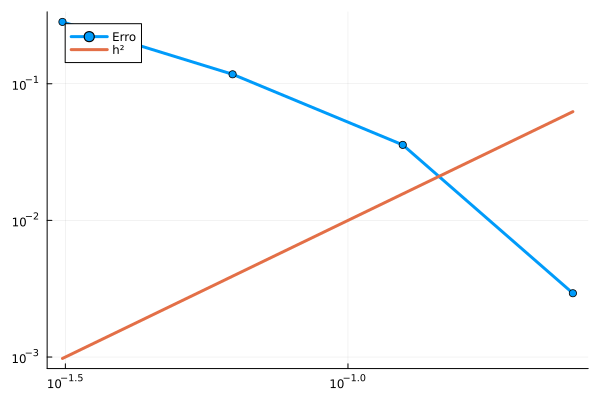

In [704]:
α = 1.0
β = 1.0

n_testes = 5
plot_erro_galerkin(n_testes, f4, f4_solution, α, β)